<a href="https://colab.research.google.com/github/kashifansaricodes/MobileVLM-V2-Integration-with-Isaac-Sim/blob/main/MobileVLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Meituan-AutoML/MobileVLM.git
%cd MobileVLM

Cloning into 'MobileVLM'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 65 (delta 15), reused 41 (delta 8), pack-reused 0
Receiving objects: 100% (65/65), 190.93 KiB | 8.30 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/MobileVLM


In [3]:
!pip install -r requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.9/809.9 kB 30.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of gradio-client to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of gradio-client to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduc

In [5]:
import sys
import torch
import argparse
from PIL import Image
from pathlib import Path

sys.path.append('/content/MobileVLM')

from mobilevlm.model.mobilevlm import load_pretrained_model
from mobilevlm.conversation import conv_templates, SeparatorStyle
from mobilevlm.utils import disable_torch_init, process_images, tokenizer_image_token, KeywordsStoppingCriteria
from mobilevlm.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN

In [6]:
model_name = 'mtgv/MobileVLM-3B'
tokenizer, model, image_processor, context_len = load_pretrained_model(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/6.07G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.07G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for vision_model.embeddings.class_embedding: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for vision_model.embeddings.patch_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for vision_model.embeddings.position_embedding.weight: copying from a non-meta para

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

In [7]:
import requests
import matplotlib.pyplot as plt


In [32]:
from PIL import Image
import torch
import matplotlib.pyplot as plt

def generate(query, img_path):
    # Open the local image file
    image = Image.open(img_path).convert('RGB')
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

    # Process the image as required by your model
    images_tensor = process_images([image], image_processor, model.config).to(model.device, dtype=torch.float16)

    conv = conv_templates['v1'].copy()
    conv.append_message(conv.roles[0], DEFAULT_IMAGE_TOKEN + "\n" + query)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2

    # Input
    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).cuda()
    stopping_criteria = KeywordsStoppingCriteria([stop_str], tokenizer, input_ids)

    # Inference
    temperature = 0.2
    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=images_tensor,
            do_sample=temperature > 0,
            temperature=temperature,
            top_p=None,
            num_beams=1,
            max_new_tokens=512,
            use_cache=True,
            stopping_criteria=[stopping_criteria],
        )

    # Result-Decode
    input_token_len = input_ids.shape[1]
    n_diff_input_output = (input_ids != output_ids[:, :input_token_len]).sum().item()
    if n_diff_input_output > 0:
        print(f"[Warning] {n_diff_input_output} output_ids are not the same as the input_ids")

    outputs = tokenizer.batch_decode(output_ids[:, input_token_len:], skip_special_tokens=True)[0].strip()
    if outputs.endswith(stop_str):
        outputs = outputs[:-len(stop_str)].strip()

    print(f" VLM Answer: {outputs}\n")


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


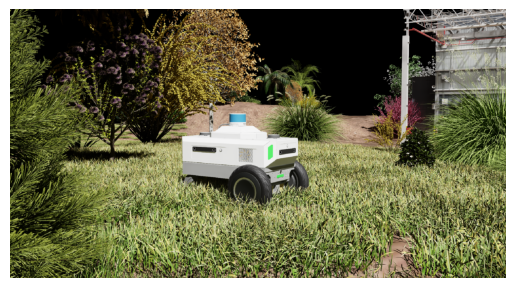

 VLM Answer: The image features a small, white robotic vehicle driving through a lush, green field. The robot is positioned in the center of the scene, surrounded by a variety of plants and trees. The field appears to be a part of a garden or a park, with the robotic vehicle being the main focus of the image.



In [33]:
query = "What do you see in the picture?"
image = '/content/drive/MyDrive/vlm/10.jpg'
generate(query, image)

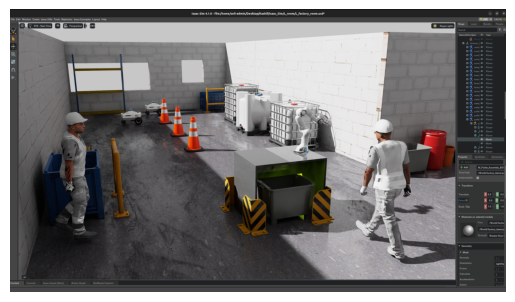

 VLM Answer: In the camera frame, there are several items visible, including a person, a truck, a building, a wall, and a pile of cones.



In [36]:
query = 'list the items you see in the camera frame?'
image = '/content/drive/MyDrive/vlm/2.png'
generate(query, image)